# One-Layer Softmax Classifier with L2 Regularization on MNIST from Scratch
- ### Visualization
- ### Preprocessing
- ### Prediction with Random Normal Parameters
- ### Building a Softmax Classifier from ground up
- ### Results of Test Set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip, pickle

In [2]:
# Numpy configurations
np.set_printoptions(precision=3, suppress=True)
np.random.seed(42)

In [3]:
# Download MNIST dataset independently
# Load MNIST dataset

with gzip.open(filename='data/mnist.pkl.gz', mode='rb') as dataset:
    (X_train, y_train), (X_valid, y_valid), (X_test, y_test) = pickle.load(file=dataset, encoding='latin1')

# Check shapes of each data:
print('Training data shape:    ', X_train.shape)
print('Training labels shape:  ', y_train.shape)
print('Validation data shape:  ', X_valid.shape)
print('Validation labels shape:', y_valid.shape)
print('Test data shape:        ', X_test.shape)
print('Test labels shape:      ', y_test.shape)

Training data shape:     (50000, 784)
Training labels shape:   (50000,)
Validation data shape:   (10000, 784)
Validation labels shape: (10000,)
Test data shape:         (10000, 784)
Test labels shape:       (10000,)


## Training Simple Softmax Calssifier with One Layer

### Visualization

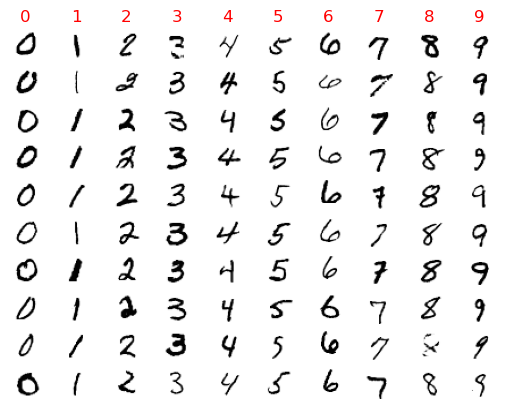

In [6]:
class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = 10
num_samples = 10    # number of illustrated samples for each class

# Plot random samples
for y, label in enumerate(class_labels):
    matching_idxs = np.flatnonzero(y_train == y)     # returns a flat version of non-zero indices
    matching_idxs = np.random.choice(a=matching_idxs, size=num_samples, replace=False)   # chooses num_samples of indices randomly

    for i, idx in enumerate(matching_idxs):
        subplot_index = (i * num_classes) + (y + 1)     # (i * num_classes) -> iterates in columns, (y + 1) -> iterates through rows
        plt.subplot(num_samples, num_classes, subplot_index)

        plt.imshow(X_train[idx].reshape(28, 28), cmap='Greys')    # MNIST images are 28 * 28 pixels

        plt.axis(False)
        # Show label of each column
        if i == 0: plt.title(label, color='red')

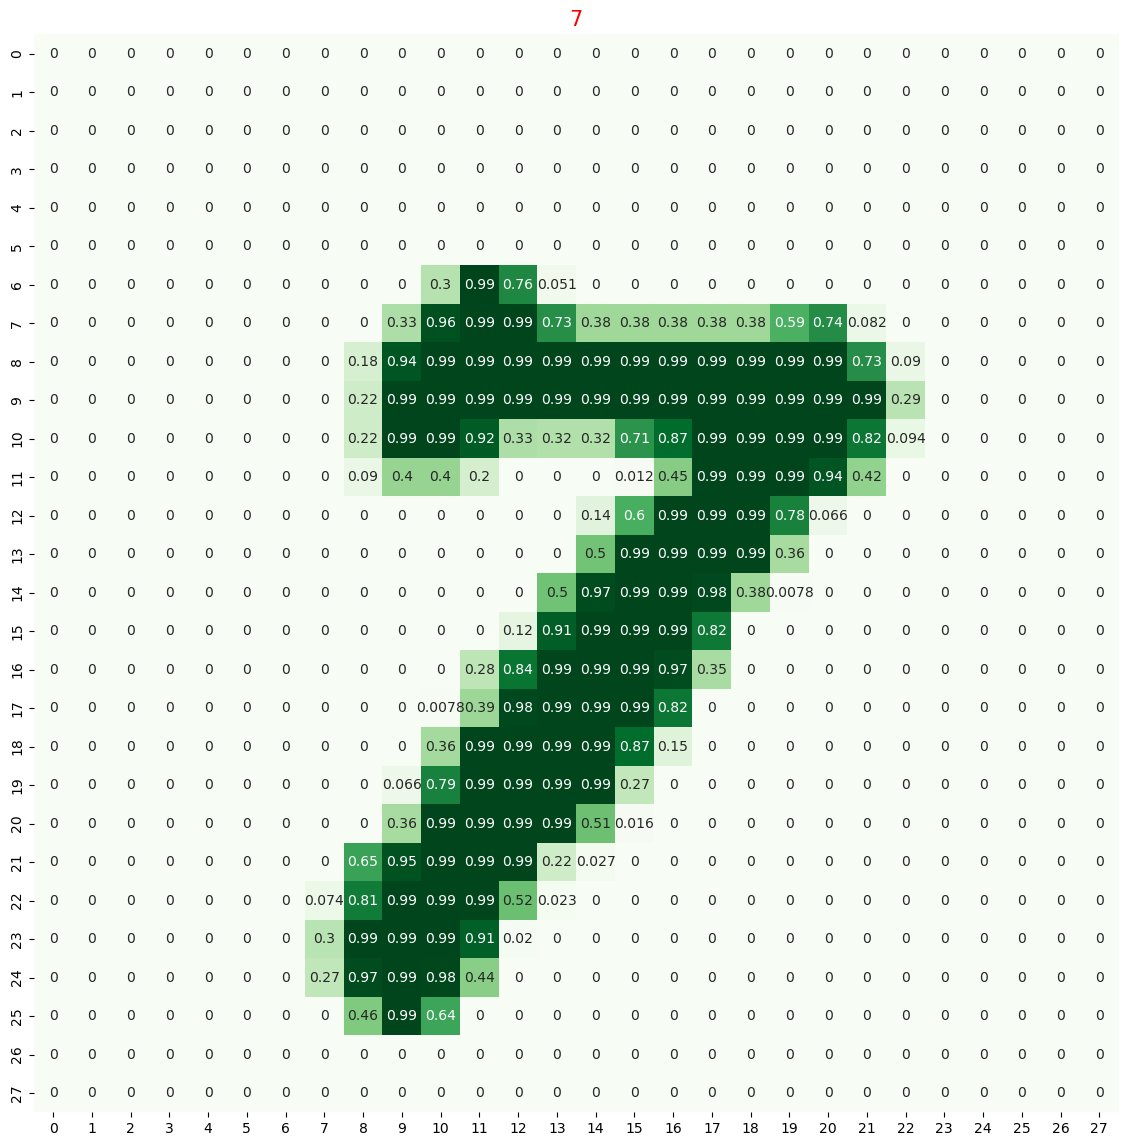

In [7]:
# Plot a single random sample
idx = np.random.randint(0, X_train.shape[0]+1)    # select a random index from valid interval

x_img = X_train[idx].reshape(28, 28)

plt.figure(figsize=(14, 14))
sns.heatmap(data=x_img, annot=True, cmap='Greens', cbar=False)
plt.title(y_train[idx], color='red', fontsize=15);

### Preprocessing Data: Normalization

In [9]:
# every pixel is scaled in [0, 1], only we need to subtract the mean from the data for stable and faster learning
print(f"0<=X<=1 ? {X_train[0].all()>=0 and X_train[0].all()<=1}")

0<=X<=1 ? True


In [10]:
# Only run this cell once
mu = X_train.mean(axis = 0)

X_train -= mu
X_valid -= mu
X_test  -= mu

In [11]:
mu.shape

(784,)

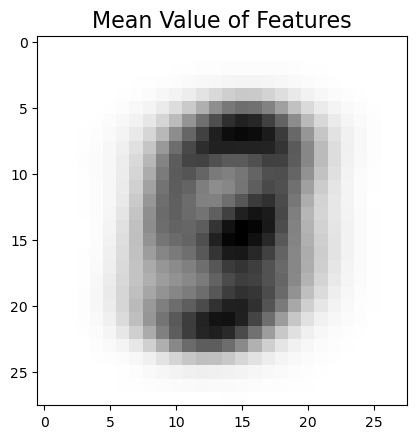

In [12]:
# Plot the mean vector
plt.imshow(mu.reshape(28, 28), cmap='Greys')
plt.title("Mean Value of Features", fontsize=16);

### Prediction with Random Normal Parameters
#### Expect the accuracy to be around $\frac{1}{\mathrm{num\_classes}}$ because weights are initilized close to 0. Thus, $P_y = \frac{\exp^{\sim 0}}{\sum_{\mathrm{num\_classes}} \exp^{\sim 0}}$

In [14]:
##############################
def predict(X, W, b):
    scores = (X @ W) + b
    return np.argmax(scores, axis=1)

# accuracy is definded as ratio of (true-positive + true-negative) predictions to the total of samples
def accuracy(y_pred, y_true):
    return np.mean(y_pred == y_true) * 100.
#############################

In [15]:
n = X_train.shape[1]    # number of features
c = num_classes

W = 0.001 * np.random.rand(n, c)   # remember that X is (m, n), where m is 50000, so Should multiply in this way: X @ W -> (m, c)
b = np.zeros(c)

y_pred = predict(X_train, W, b)
acc = accuracy(y_pred, y_train)

print(f"Accuracy with randomly initilized weights: {acc:4}%")

Accuracy with randomly initilized weights: 10.186%


### Building a Softmax Classifier

In [17]:
def softmax(scores):
    scores -= np.max(scores, axis=1, keepdims=True)   # np.exp(values) wont' explode anymore
    exp_scores = np.exp(scores) 
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def cross_entropy_loss_gradients(X, y, W, b, mode='train'):
    """
    Calculate Cross-entropy loss + Gradients of Weigths and bias
    - if mode='train' -> returns loss, dW, db.
    - if mode='test' -> retursn loss.
    """
    m = X.shape[0]          # here batch size is bs = m
    
    scores = X @ W + b
    probs = softmax(scores)
    # selecting the correct class probabilities in the most inner paranthesis
    loss = (1 / m) * -np.sum(np.log(probs[range(m), y])) # Softmax loss formula
    
    if mode == 'test':
        return loss

    # Calculate Gradients
    # Compute gradients with respect to scores
    dscores = np.copy(probs)
    dscores[range(m), y] -= 1   # subtract 1 from the probability of the correct class(y) for each sample(range(m)).
    dscores /= m
    
    # Compute gradients w.r.t W and b; for formulas, Lookup on the internet; the gradients are derived from the chain rule
    db = dscores.sum(axis=0)
    dW = X.T @ dscores
    
    return loss, dW, db

In [18]:
def mini_batch_gradient_descent(X_train, y_train, X_valid, y_valid, batch_size=64,
                                alpha=0.01, lmbda=1e-4, num_epochs=100):
    m, n = X_train.shape
    c = 10
    num_batches = m % batch_size   # we ignore the remainder

    # Initilize prameters randomly
    W = 1e-3 * np.random.randn(n, c)
    b = np.zeros(c)

    # Training the data batches
    for epoch in range(num_epochs):
        epoch_train_loss = 0.

        # Training on single batch
        for batch in range(num_batches):

            # Randomly select a mini-batch
            idxs = np.random.choice(m, batch_size, replace=False)
            X_batch, y_batch = X_train[idxs], y_train[idxs]

            # Compute cross-entropy loss and gradients
            loss, dW, db = cross_entropy_loss_gradients(X_batch, y_batch, W, b, 'train')
            loss += 0.5 * lmbda * np.sum(W ** 2)   # L2 Regularization Term
            dW += lmbda * W
            
            epoch_train_loss += loss

            # Update weights and bias
            W -= alpha * dW
            b -= alpha * db
                  
        # report statistics after each epoch
        epoch_train_loss /= num_batches     # calculate average train loss per batch
        total_valid_loss = cross_entropy_loss_gradients(X_valid, y_valid, W, b, mode='test')
        
        print(f"Epoch {epoch+1:3} || training loss: {epoch_train_loss:.4f} || validation loss: {total_valid_loss:.4f}")

        
        if (epoch + 1) % 10 == 0:
                train_accuracy = accuracy(predict(X_train, W, b), y_train)
                valid_accuracy = accuracy(predict(X_valid, W, b), y_valid)
                print(f"----train accuracy: {train_accuracy:.4f} || validation accuracy: {valid_accuracy:.4f}----")

    return W, b

### Training the Softmax Classifier Model

In [20]:
W, b = mini_batch_gradient_descent(X_train, y_train, X_valid, y_valid, batch_size=128,
                                   alpha=.03, lmbda=.004, num_epochs=70)

Epoch   1 || training loss: 1.5407 || validation loss: 1.0658
Epoch   2 || training loss: 0.9594 || validation loss: 0.7783
Epoch   3 || training loss: 0.7755 || validation loss: 0.6559
Epoch   4 || training loss: 0.6989 || validation loss: 0.5877
Epoch   5 || training loss: 0.6350 || validation loss: 0.5431
Epoch   6 || training loss: 0.5953 || validation loss: 0.5116
Epoch   7 || training loss: 0.5819 || validation loss: 0.4893
Epoch   8 || training loss: 0.5569 || validation loss: 0.4707
Epoch   9 || training loss: 0.5508 || validation loss: 0.4558
Epoch  10 || training loss: 0.5328 || validation loss: 0.4440
----train accuracy: 87.4620 || validation accuracy: 89.1000----
Epoch  11 || training loss: 0.5294 || validation loss: 0.4337
Epoch  12 || training loss: 0.5168 || validation loss: 0.4256
Epoch  13 || training loss: 0.5040 || validation loss: 0.4180
Epoch  14 || training loss: 0.5004 || validation loss: 0.4113
Epoch  15 || training loss: 0.4897 || validation loss: 0.4057
Epoch 

In [21]:
train_acc = accuracy(predict(X_train, W, b), y_train)
valid_acc = accuracy(predict(X_valid, W, b), y_valid)

print('Training accuracy =   {:.2f}%'.format(train_acc))
print('Validation accuracy = {:.2f}%'.format(valid_acc))

Training accuracy =   90.29%
Validation accuracy = 91.23%


In [64]:
# prediction on the the test set

test_acc = accuracy(predict(X_test, W, b), y_test)
print(f'Test accuracy =   {test_acc:.2f}%')

Test accuracy =   90.83%


### Visualize 4 Random Predictions

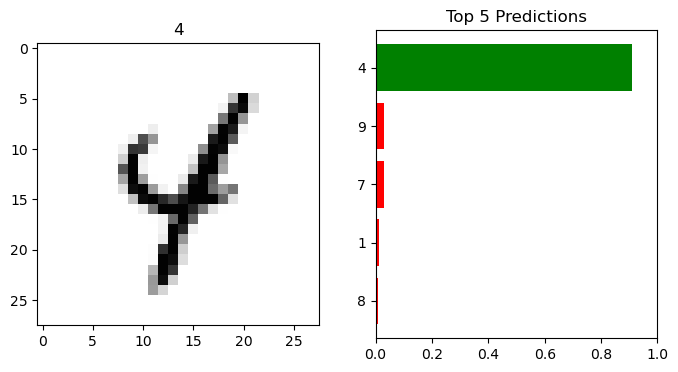

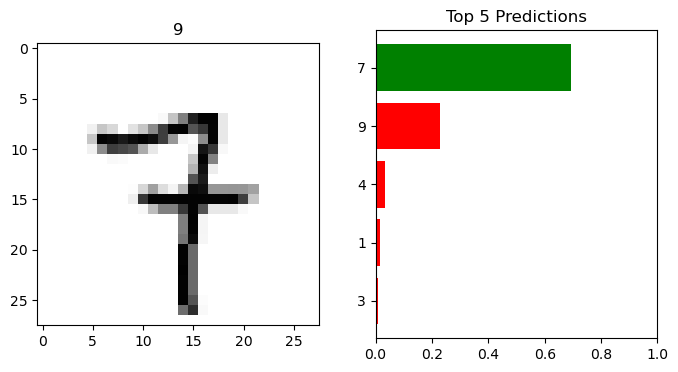

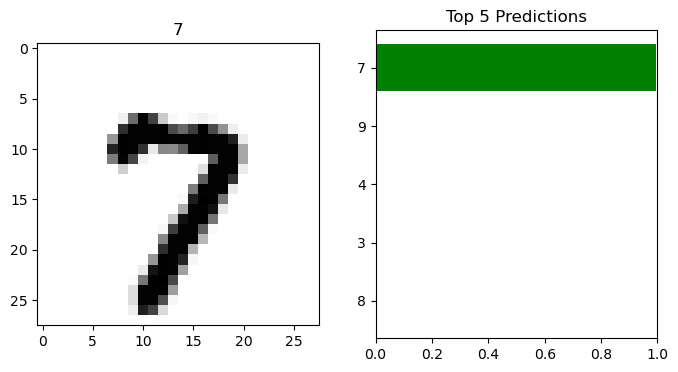

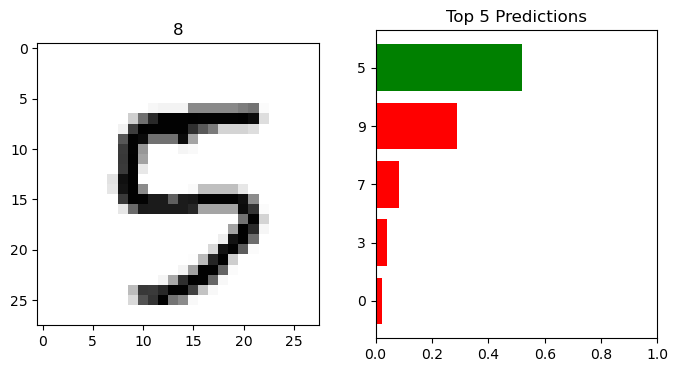

In [100]:
for _ in range(4):
    plt.figure(figsize=(8, 4))
    
    idx = np.random.choice(X_test.shape[0])
    x = X_test[idx]
    probabilities = softmax(x.reshape(1, -1) @ W + b)[0]
    
    # Plot the digit
    plt.subplot(121)
    x = x + mu
    plt.imshow(x.reshape(28, 28), cmap='Greys')
    plt.title(class_labels[predict(x.reshape(1, -1), W, b)[0]])
    
    # Plot top 5 predictions
    idxs = np.argsort(probabilities)[5:]
    tick_label = [class_labels[i] for i in idxs]
    color = ['g' if i == y_test[idx] else 'r' for i in idxs]
    
    plt.subplot(122)
    plt.barh(range(5), width=probabilities[idxs], tick_label=tick_label, color=color)
    plt.xlim(0, 1)
    plt.title("Top 5 Predictions")

### Visualize Learned Weights

In [107]:
print(f"W.shape = {W.shape}")

W.shape = (784, 10)


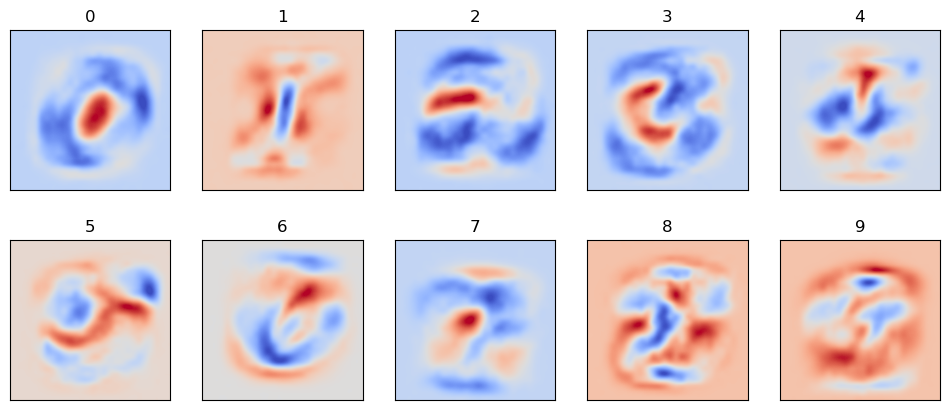

In [121]:
# Plot weights
plt.figure(figsize=(12, 5))
for i in range(num_classes):
    plt.subplot(2, 5, i+1)
    w_i = W[:, i]
    plt.imshow(w_i.reshape(28, 28), cmap='coolwarm_r', interpolation='spline16')
    
    plt.title(i)
    plt.xticks(())
    plt.yticks(())